# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## **SUBMISSION**
**Parallel computing** is done in order to **increase the efficiency of a program** and allows to **solve different problems at same time using many processors (CPU)**. This reduces the computing time. There are several methods for parallelization. For this exercise I used **Single Program Multiple Data (SPMD)**: a single program is computed with different data on different processors and all the processes comunicate and exchange informations with a single **buffer**. Each process has an integer key called **rank**. In order to do this I used **Message Passing Interface (MPI) libraries** for `c++` *which implements the message passing model on parallel computers thus giving the possibility to processes running on different CPUs to synchronize information even if a common address space for memory (generally distributed) is lacking*. The MPI methods I used for this execercise are:
* `MPI_Init(&argc, &argv)`: it initializes the parallelization, given command line variables, for example to specify the number of processes.
* `MPI_Finalize()`: it terminates the parallelization.
* `MPI_Comm_size(MPI_COMM_WORLD, &world_size)`: it is used to make the single process aware of how many processes are working simultaniously.
* `MPI_Comm_rank(MPI_COMM_WORLD, &world_rank)`: it assignes the **rank** to the current process.
* `MPI_Wtime()`: it measures the time passed up to the moment this method is called. I call it at the beginning of the program and a the end: the time of the simulation is estimated by the difference between them (reported in `output.dat`).
* `MPI_Irecv()`: it is a **non-blocking communication** subroutine which allows to recieve an information from an other process. **Non-blocking** means that the program returns from the subroutine method before making sure that the copy from the buffer is completed. I used non-blocking communication because it is faster than the blocking one.
* `MPI_Isend()`: it is the same of `MPI_Irecv()` but used to send an information to the buffer.
* `MPI_Wait()`: it makes sure that the copy to or from the buffer is completed correctly.

### **EX - 10.1**
For this exercise I parallelized my GA in order to solve TSP. After $N_{migr}=50$ generations the best $n_{migr}$ configurations of a continent are sent to the following one. At the same time, the same continent recieves the best $n_{migr}$ configurations of the previous one. The [utils.cpp](utils.cpp) file has the same structure of exercise 09.1 but has some changes: I print only $rank=0$ outputs, the file [output.dat](./OUTPUT/CIRCLE/output.dat) gives also the information about the parallelization. What has changed is [tsp.cpp](tsp.cpp). The initial configuration has to be the same for all the processes so I generated it before calling `MPI_Init()`. In order to do this I initialized `Random` variable with the first line of [Primes](./Primes). For every process I initialized `Random` with a different line of [Primes](./Primes) as follow:
```cpp
int main(int argc, char* argv[]){
	Random rnd;
    rnd.Initialize(0);
    TSP tsp;
    element e(tsp.get_cities());
    e.generate_initial_config(rnd,tsp.get_circle());
    int n_migr=1; //number of element to exchange in the migration
    MPI_Init(&argc,&argv);
    int world_size;
    MPI_Comm_size(MPI_COMM_WORLD, &world_size);
    int world_rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);
    double t_start= MPI_Wtime();
    rnd.Initialize(world_rank);
	//...
}
```
Where `Initialize` method is:
```cpp
void Random :: Initialize(int rank){
   int seed[4];
   int p1, p2;
   ifstream Primes("Primes");
   if (Primes.is_open()){
      for(int k=0; k<=rank; k++){
         Primes >> p1 >> p2 ;
      }
   } else cerr << "PROBLEM: Unable to open Primes" << endl;
   Primes.close();
   ifstream input("seed.in");
   string property;
   if (input.is_open()){
      while ( !input.eof() ){
         input >> property;
         if( property == "RANDOMSEED" ){
            input >> seed[0] >> seed[1] >> seed[2] >> seed[3];
            this->SetRandom(seed,p1,p2);
         }
      }
      input.close();
   } else cerr << "PROBLEM: Unable to open seed.in" << endl;

}
```

The code I used for the migration is:
```cpp
//...
if(i%50==0){ //every 50 generations send the first n_migr configurations at the following process, and recive the first n_migr from the previous process

	int prev = (world_rank - 1 + world_size) % world_size;
	int next = (world_rank + 1) % world_size;

	for(int j=0; j<n_migr; j++){

		std::vector<int> message_to_send=pop.get_element(j).get_label();
		std::vector<int> message_received(tsp.get_cities());

		MPI_Request send_request, recv_request;
		MPI_Status status;

		MPI_Irecv(message_received.data(), message_received.size(), MPI_INT, prev, j, MPI_COMM_WORLD, &recv_request);
		MPI_Isend(message_to_send.data(), message_to_send.size(), MPI_INT, next, j, MPI_COMM_WORLD, &send_request);

		MPI_Wait(&recv_request, &status);
		MPI_Wait(&send_request, &status);

		element recieved(pop.get_element(j));
		recieved.set_label(message_received);

		pop.Set_element(j,recieved);
	}
}
//...
```
In this case I have to pass a vector of integer numbers which contains a configuration. The sintax to ensure a **correct bidirectional communication** requires that a single process recieves and sends at the same time a message and for both calls `MPI_Wait()` makes sure that the copy is completed. `MPI_INT` specifies the variable type which has to be passed.

All the informations with the best parameters about this exercise are stored in `output.dat` file in `./OUTPUT/CIRCLE/` and `./OUTPUT/SQUARE/` paths.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

In [24]:
best_pos_circle=np.loadtxt("./OUTPUT/CIRCLE/PATHS/path_150.dat")
loss=np.loadtxt("./OUTPUT/CIRCLE/best_loss.dat")
half_loss=np.loadtxt("./OUTPUT/CIRCLE/half_loss.dat")

best_pos_square=np.loadtxt("./OUTPUT/SQUARE/PATHS/path_150.dat")
loss_square=np.loadtxt("./OUTPUT/SQUARE/best_loss.dat")
half_loss_square=np.loadtxt("./OUTPUT/SQUARE/half_loss.dat")

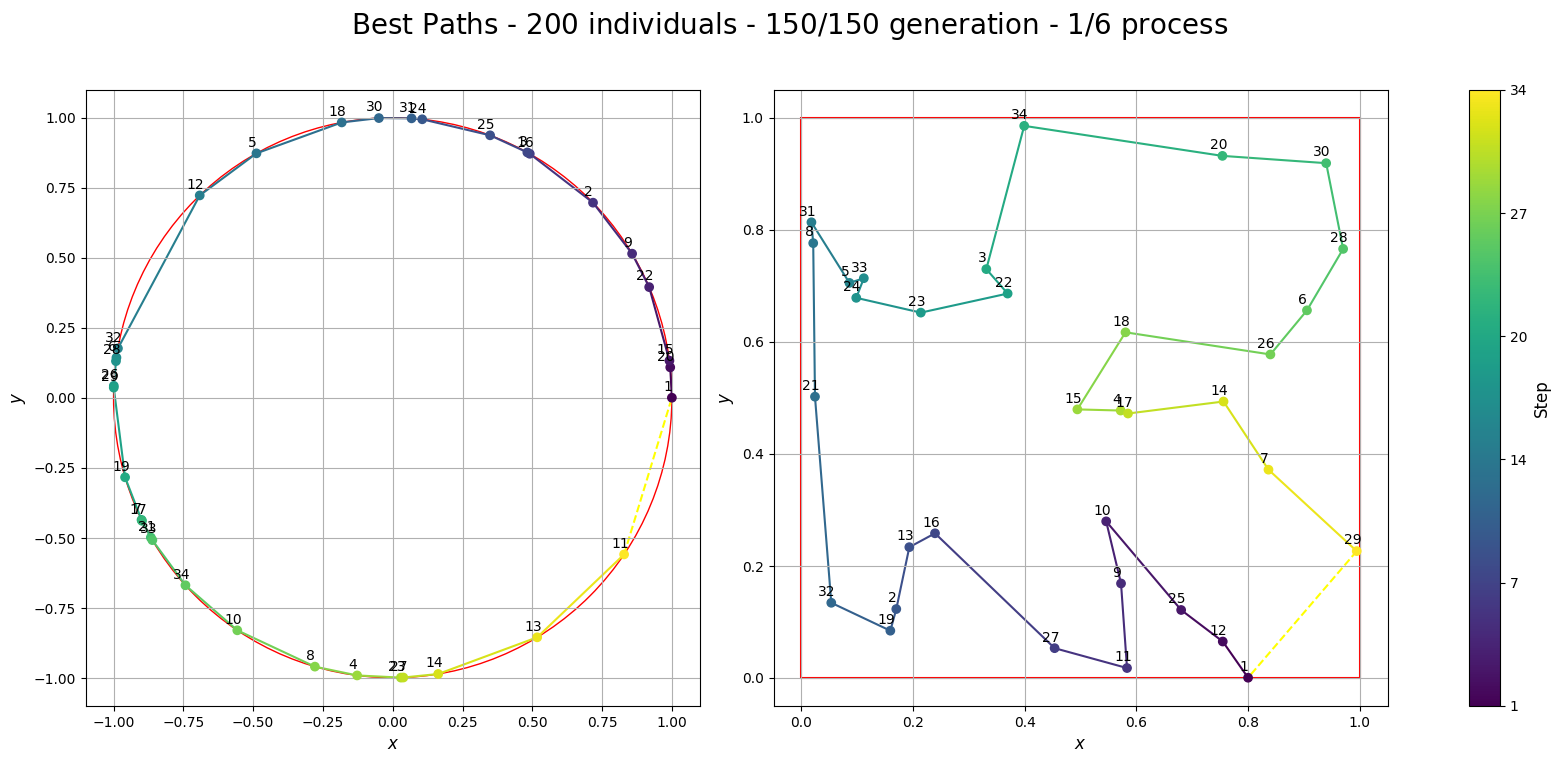

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(21,8), gridspec_kw={'wspace':0.12})

circle = patches.Circle((0, 0), radius=1, edgecolor='r', facecolor='none')
axs[0].add_patch(circle)
steps = np.arange(len(best_pos_circle))
cmap = plt.get_cmap('viridis')
colors = cmap(steps / steps.max())
sc=axs[0].scatter(best_pos_circle[:,1], best_pos_circle[:,2], color=colors, zorder=2)

for i, (x, y) in enumerate(zip(best_pos_circle[:,1], best_pos_circle[:,2])):
    axs[0].plot( best_pos_circle[i:i+2,1], best_pos_circle[i:i+2,2], color=colors[i], zorder=1)
    axs[0].annotate(f'{int(best_pos_circle[i,0])}', (x, y), color='black',textcoords="offset points", xytext=(-3,5), ha='center')

axs[0].plot( [best_pos_circle[len(best_pos_circle)-1,1],best_pos_circle[0,1]], [best_pos_circle[len(best_pos_circle)-1,2],best_pos_circle[0,2]], color='yellow', linestyle='--',zorder=1)
axs[0].set_xlabel(r'$x$',fontsize=12)
axs[0].set_ylabel(r'$y$',fontsize=12)
axs[0].grid(True)

square = patches.Rectangle((0, 0), 1, 1, linewidth=1.5, edgecolor='r', facecolor='none')
axs[1].add_patch(square)
sc=axs[1].scatter(best_pos_square[:,1], best_pos_square[:,2], color=colors, zorder=2)

for i, (x, y) in enumerate(zip(best_pos_square[:,1], best_pos_square[:,2])):
    axs[1].plot( best_pos_square[i:i+2,1], best_pos_square[i:i+2,2], color=colors[i], zorder=1)
    axs[1].annotate(f'{int(best_pos_square[i,0])}', (x, y), color='black',textcoords="offset points", xytext=(-3,5), ha='center')

axs[1].plot( [best_pos_square[len(best_pos_square)-1,1],best_pos_square[0,1]], [best_pos_square[len(best_pos_square)-1,2],best_pos_square[0,2]], color='yellow', linestyle='--',zorder=1)
axs[1].set_xlabel(r'$x$',fontsize=12)
axs[1].set_ylabel(r'$y$',fontsize=12)
axs[1].grid(True)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=steps.max()+1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical')
cbar.set_label('Step', fontsize=12)
ticks = np.linspace(1, steps.max()+1, num=6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{int(tick)}' for tick in ticks]) 

plt.suptitle(r'Best Paths - $200$ individuals - $150/150$ generation - $1/6$ process',x=0.46,fontsize=20)
plt.show()

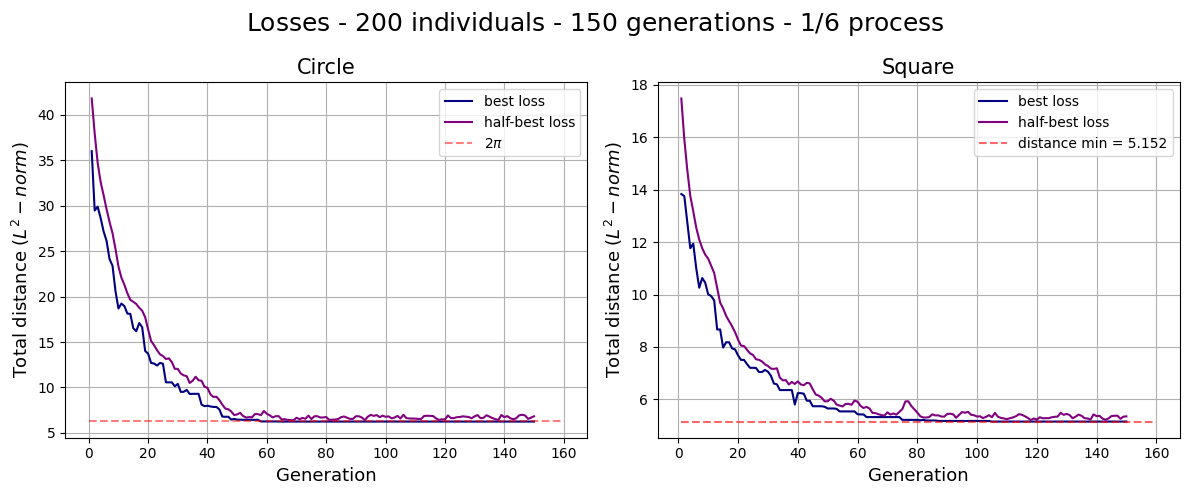

In [49]:
fig=plt.figure(figsize=(12,5))

ax1=fig.add_subplot(1,2,1)
ax1.plot(loss[:,0],loss[:,1],color='navy',label=r'best loss')
ax1.plot(half_loss[:,0],half_loss[:,1],color='purple',label=r'half-best loss')
ax1.hlines(2*np.pi,xmin=0,xmax=160,color='r',linestyles='--',alpha=0.5,label=r'$2\pi$')
ax1.set_xlabel(r'Generation',fontsize=13)
ax1.set_ylabel(r'Total distance ($L^2-norm$)',fontsize=13)
ax1.set_title(r'Circle',fontsize=15)
ax1.legend()
ax1.grid(True)

ax2=fig.add_subplot(1,2,2)
ax2.plot(loss_square[:,0],loss_square[:,1],color='navy',label=r'best loss')
ax2.plot(half_loss_square[:,0],half_loss_square[:,1],color='purple',label=r'half-best loss')
ax2.hlines(loss_square[-1,1],xmin=loss_square[0,0],xmax=(loss_square[-1,0]+10),color='r',alpha=0.6,linestyles='--',label=f'distance min = {round(loss_square[-1,1],3)}')
ax2.set_xlabel(r'Generation',fontsize=13)
ax2.set_ylabel(r'Total distance ($L^2-norm$)',fontsize=13)
ax2.set_title(r'Square',fontsize=15)
ax2.legend()
ax2.grid(True)

plt.suptitle(r'Losses - $200$ individuals - $150$ generations - $1/6$ process',fontsize=18)
plt.tight_layout()
plt.show()

Run the following cells to create the GIF and to visualize it.

In [43]:
# gif creation

#PATHS
circle_path_dir = 'OUTPUT/CIRCLE/PATHS'
square_path_dir = 'OUTPUT/SQUARE/PATHS'
n_generations = 150

#LOADING PATHS
def load_generation_data(generation):
    circle_file = os.path.join(circle_path_dir, f'path_{generation}.dat')
    square_file = os.path.join(square_path_dir, f'path_{generation}.dat')

    pos_circle = np.loadtxt(circle_file)
    pos_square = np.loadtxt(square_file)
    
    return pos_circle, pos_square

In [52]:
def gif(gens):
     files=[]
     for i in gens:
        file = 'OUTPUT/IMAGES/best_path_' + str(i) + '.png'
        files.append(file) 
        fig,axs=plt.subplots(1, 2, figsize=(21,8), gridspec_kw={'wspace':0.12})
        circle = patches.Circle((0, 0), radius=1, edgecolor='r', facecolor='none')
        axs[0].add_patch(circle)
        square = patches.Rectangle((0, 0), 1, 1, linewidth=1.5, edgecolor='r', facecolor='none')
        axs[1].add_patch(square)
        cmap = plt.get_cmap('viridis')
        axs[0].add_patch(patches.Circle((0, 0), radius=1, edgecolor='r', facecolor='none'))
        axs[1].add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=1.5, edgecolor='r', facecolor='none'))

        pos_circle, pos_square = load_generation_data(str(i + 1) )

        steps = np.arange(len(pos_circle))
        colors = cmap(steps / steps.max())

        axs[0].scatter(pos_circle[:,1], pos_circle[:,2], color=colors, zorder=2)
        for j in range(len(pos_circle) - 1):
            axs[0].plot(pos_circle[j:j+2,1], pos_circle[j:j+2,2], color=colors[j], zorder=1)
            axs[0].annotate(f'{int(pos_circle[j,0])}', (pos_circle[j,1], pos_circle[j,2]), color='black', 
                            textcoords="offset points", xytext=(-3,5), ha='center')

        axs[0].plot([pos_circle[-1,1], pos_circle[0,1]], [pos_circle[-1,2], pos_circle[0,2]], 
                    color='yellow', linestyle='--', zorder=1)

        axs[1].scatter(pos_square[:,1], pos_square[:,2], color=colors, zorder=2)
        for j in range(len(pos_square) - 1):
            axs[1].plot(pos_square[j:j+2,1], pos_square[j:j+2,2], color=colors[j], zorder=1)
            axs[1].annotate(f'{int(pos_square[j,0])}', (pos_square[j,1], pos_square[j,2]), color='black', 
                            textcoords="offset points", xytext=(-3,5), ha='center')

        axs[1].plot([pos_square[-1,1], pos_square[0,1]], [pos_square[-1,2], pos_square[0,2]], 
                    color='yellow', linestyle='--', zorder=1)

        axs[0].set_xlabel(r'$x$', fontsize=12)
        axs[0].set_ylabel(r'$y$', fontsize=12)
        axs[0].grid(True)

        axs[1].set_xlabel(r'$x$', fontsize=12)
        axs[1].set_ylabel(r'$y$', fontsize=12)
        axs[1].grid(True)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=steps.max()+1))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axs, orientation='vertical')
        cbar.set_label('Step', fontsize=12)
        ticks = np.linspace(1, steps.max()+1, num=6)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f'{int(tick)}' for tick in ticks])
        fig.suptitle(f'Best Paths - 200 individuals - Generation {str(i+1)}/{n_generations} - 1/6 process', x=0.5,fontsize=20)
        fig.savefig(file)
        plt.close()
    
     images = [Image.open(file) for file in files]
     out_path = './OUTPUT/best_path.gif'
     images[0].save(out_path, save_all=True, append_images=images[1:], optimize=False, duration=150, loop=0)
     for image in images :
        image.close()
     for file in files :
         os.remove(file)


gens = np.arange(n_generations)
gif(gens)

In [53]:
out_path = './OUTPUT/best_path.gif'
HTML(f"<img src='{out_path}' style='width: 10000px;'/>")

### **EX - 10.2**

For this exercise I modified [utils.cpp](./utils.cpp) in order to read input files [prov_ita.txt](./INPUT/prov_ita.txt) and [cap_prov_it.dat](./INPUT/cap_prov_ita.dat) which contains respectively the names of the italians cities and their positions.

The best parameters are stored in [output.dat](./OUTPUT/ITALY/output.dat) and the best result is still obtained for $n_{migr}=1$. As we can see from the loss and from the GIF, after about $600$ generations the loss changes more slowly until it reaches the minimun. The GIF shows that a **little change in the loss value could not correspond to a little change in the configuration**. This is due to the migration: a minimum configuration in a process could have a loss which is a little bit lower than the one of the first process but their configurations could have many differences. The more the generations grow the less the configuration can change, because the entropy decreases.

I found out that the **results with migration are better** than the ones without it. Indeed I perfomed two simulations with the same parameters, with independent search and with migration. In the first case, the first process reaches minimum loss value at $71.227$. Whereas with migration the minimum loss value of the first process is $65.322$. 

The cause is linked to what I said above: there could be various configurations which may have many differences between them. Indeed when I use indipendent search each process evolves its population visiting only the nearest minimum to the starting population. Whereas with migration every process is able to visit a bigger region and thus finding a lower minimum than before. I used $N_{migr}=50$: it is a good choice beacuse it gives time to a process to evolve his population with new individuals and also gives the possibility to the first process to recieve individual from all the other processes (in this case I used 10 processes).

In [2]:
best_pos_it=np.loadtxt("./OUTPUT/ITALY_WM/PATHS/path_1100.dat")
best_loss_it=np.loadtxt("./OUTPUT/ITALY_WM/best_loss.dat")
half_loss_it=np.loadtxt("./OUTPUT/ITALY_WM/half_loss.dat")

best_pos_it_s=np.loadtxt("./OUTPUT/ITALY/PATHS/path_1100.dat")
best_loss_it_s=np.loadtxt("./OUTPUT/ITALY/best_loss.dat")
half_loss_it_s=np.loadtxt("./OUTPUT/ITALY/half_loss.dat")

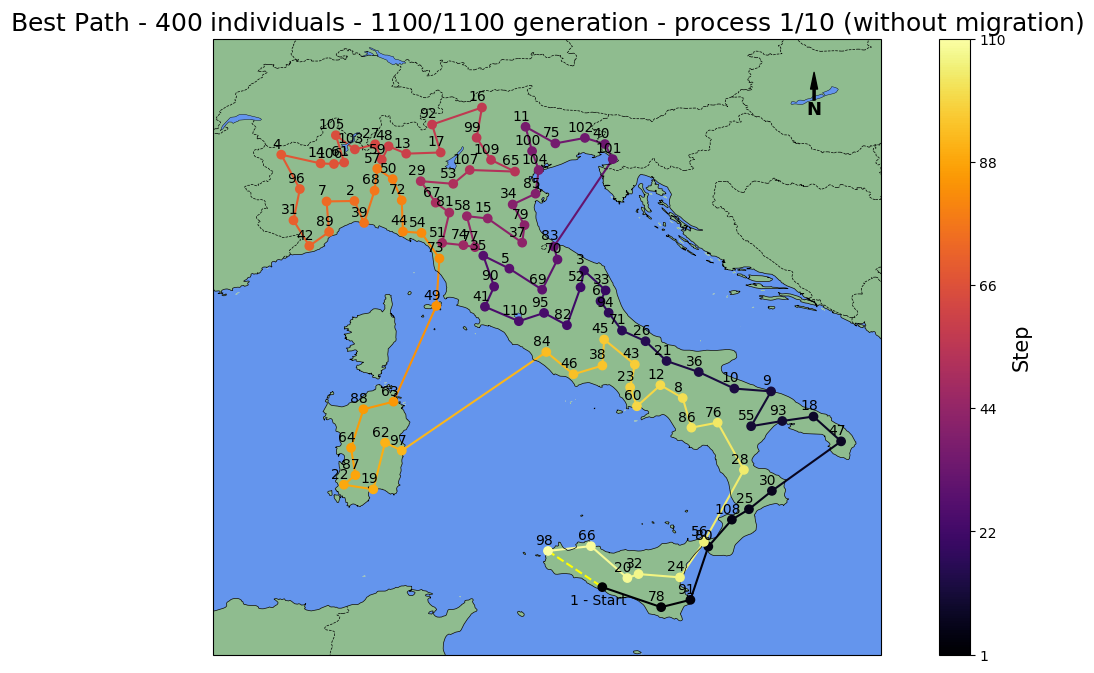

In [4]:
def add_compass(ax, loc_x=0.9, loc_y=0.9, size=13):
    # Posiziona il testo 'N'
    compass_text = ax.text(loc_x, loc_y-0.014, 'N', fontsize=size,weight='bold', ha='center', va='center', transform=ax.transAxes)
    
    # Posiziona la freccia (Nord) sopra la lettera 'N'
    ax.annotate('', xy=(loc_x, loc_y + 0.045), xytext=(loc_x, loc_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=1.5, headwidth=5))


fig, axs = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02})

axs.set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())
axs.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
axs.add_feature(cfeature.LAND, facecolor='darkseagreen')
axs.add_feature(cfeature.COASTLINE, lw=0.5)
axs.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
axs.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)

steps = np.arange(len(best_pos_it_s))
cmap = plt.get_cmap('inferno')
colors = cmap(steps / steps.max())
sc=axs.scatter(best_pos_it_s[:,1], best_pos_it_s[:,2], color=colors, zorder=2)

for i, (x, y) in enumerate(zip(best_pos_it_s[:,1], best_pos_it_s[:,2])):
    axs.plot( best_pos_it_s[i:i+2,1], best_pos_it_s[i:i+2,2], color=colors[i], zorder=1)
    if(i==0):
        axs.annotate(f'{int(best_pos_it_s[i,0])} - Start', (x, y), color='black',textcoords="offset points", xytext=(-3,-12), ha='center')
    else:
        axs.annotate(f'{int(best_pos_it_s[i,0])}', (x, y), color='black',textcoords="offset points", xytext=(-3,5), ha='center')

axs.plot( [best_pos_it_s[len(best_pos_it_s)-1,1],best_pos_it_s[0,1]], [best_pos_it_s[len(best_pos_it_s)-1,2],best_pos_it_s[0,2]], color='yellow', linestyle='--',zorder=1)
axs.set_xlabel(r'$x$',fontsize=12)
axs.set_ylabel(r'$y$',fontsize=12)
axs.grid(True)
axs.set_title(r'Best Path - $400$ individuals - $1100/1100$ generation - process $1/10$ (without migration)',fontsize=18)
add_compass(axs)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=steps.max()+1))
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=axs, orientation='vertical')
cbar.set_label('Step', fontsize=15)
ticks = np.linspace(1, steps.max()+1, num=6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{int(tick)}' for tick in ticks]) 

plt.show()

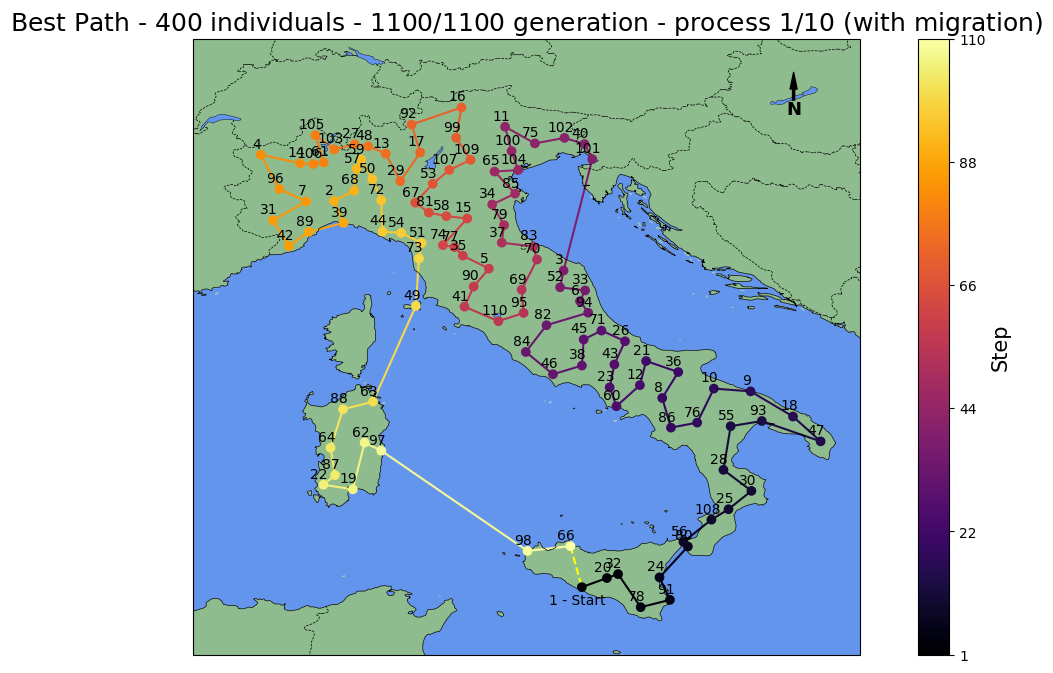

In [3]:
def add_compass(ax, loc_x=0.9, loc_y=0.9, size=13):
    # Posiziona il testo 'N'
    compass_text = ax.text(loc_x, loc_y-0.014, 'N', fontsize=size,weight='bold', ha='center', va='center', transform=ax.transAxes)
    
    # Posiziona la freccia (Nord) sopra la lettera 'N'
    ax.annotate('', xy=(loc_x, loc_y + 0.045), xytext=(loc_x, loc_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=1.5, headwidth=5))


fig, axs = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02})

axs.set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())
axs.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
axs.add_feature(cfeature.LAND, facecolor='darkseagreen')
axs.add_feature(cfeature.COASTLINE, lw=0.5)
axs.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
axs.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)

steps = np.arange(len(best_pos_it))
cmap = plt.get_cmap('inferno')
colors = cmap(steps / steps.max())
sc=axs.scatter(best_pos_it[:,1], best_pos_it[:,2], color=colors, zorder=2)

for i, (x, y) in enumerate(zip(best_pos_it[:,1], best_pos_it[:,2])):
    axs.plot( best_pos_it[i:i+2,1], best_pos_it[i:i+2,2], color=colors[i], zorder=1)
    if(i==0):
        axs.annotate(f'{int(best_pos_it[i,0])} - Start', (x, y), color='black',textcoords="offset points", xytext=(-3,-12), ha='center')
    else:
        axs.annotate(f'{int(best_pos_it[i,0])}', (x, y), color='black',textcoords="offset points", xytext=(-3,5), ha='center')

axs.plot( [best_pos_it[len(best_pos_it)-1,1],best_pos_it[0,1]], [best_pos_it[len(best_pos_it)-1,2],best_pos_it[0,2]], color='yellow', linestyle='--',zorder=1)
axs.set_xlabel(r'$x$',fontsize=12)
axs.set_ylabel(r'$y$',fontsize=12)
axs.grid(True)
axs.set_title(r'Best Path - $400$ individuals - $1100/1100$ generation - process $1/10$ (with migration)',fontsize=18)
add_compass(axs)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=steps.max()+1))
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=axs, orientation='vertical')
cbar.set_label('Step', fontsize=15)
ticks = np.linspace(1, steps.max()+1, num=6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{int(tick)}' for tick in ticks]) 

plt.show()

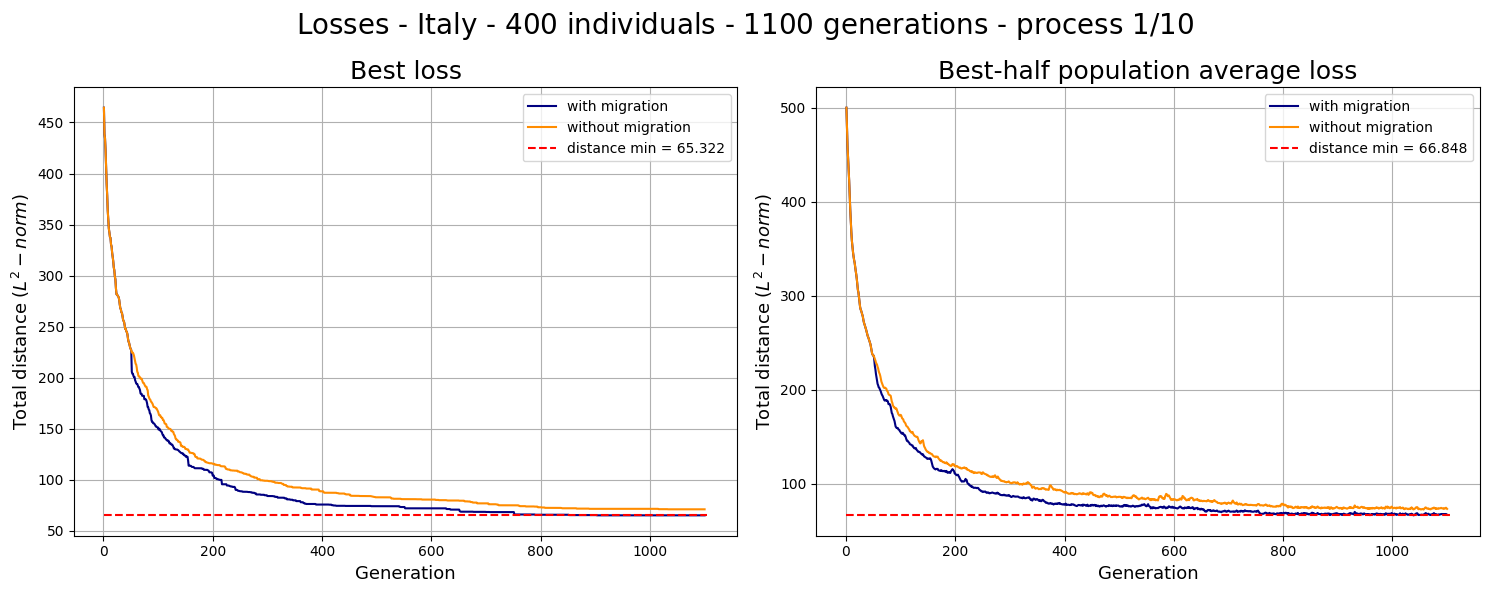

In [13]:
fig=plt.figure(figsize=(15,6))

ax1=fig.add_subplot(1,2,1)
ax1.plot(best_loss_it[:,0],best_loss_it[:,1],color='navy',label=r'with migration')
ax1.plot(best_loss_it_s[:,0],best_loss_it_s[:,1],color='darkorange',label=r'without migration')
ax1.hlines(best_loss_it[-1,1],xmin=best_loss_it[0,0],xmax=(best_loss_it[-1,0]+5),color='r',linestyles='--',label=f'distance min = {round(best_loss_it[-1,1],3)}')
ax1.set_xlabel(r'Generation',fontsize=13)
ax1.set_ylabel(r'Total distance ($L^2-norm$)',fontsize=13)
ax1.set_title(r'Best loss',fontsize=18)
ax1.legend()
ax1.grid(True)

ax2=fig.add_subplot(1,2,2)
ax2.plot(half_loss_it[:,0],half_loss_it[:,1],color='navy',label=r'with migration')
ax2.plot(half_loss_it_s[:,0],half_loss_it_s[:,1],color='darkorange',label=r'without migration')
ax2.hlines(half_loss_it[-1,1],xmin=half_loss_it[0,0],xmax=(half_loss_it[-1,0]+5),color='r',linestyles='--',label=f'distance min = {round(half_loss_it[-1,1],3)}')
ax2.set_xlabel(r'Generation',fontsize=13)
ax2.set_ylabel(r'Total distance ($L^2-norm$)',fontsize=13)
ax2.set_title(r'Best-half population average loss',fontsize=18)
ax2.legend()
ax2.grid(True)

plt.suptitle(r'Losses - Italy - $400$ individuals - $1100$ generations - process $1/10$',fontsize=20)
plt.tight_layout()
plt.show()

Run the following cells to create the GIF and to visualize it.

In [115]:
n_generations_it=1100

def gif_it(gens):
     files=[]
     for i in gens:
        file = 'OUTPUT/IMAGES/best_path_' + str(i) + '.png'
        files.append(file) 
        fig, axs = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02})
        axs.set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())
        axs.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
        axs.add_feature(cfeature.LAND, facecolor='darkseagreen')
        axs.add_feature(cfeature.COASTLINE, lw=0.5)
        axs.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
        axs.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)
        pos_it=np.loadtxt("./OUTPUT/ITALY/PATHS/path_"+str(i+1)+".dat")
        steps = np.arange(len(pos_it))
        cmap = plt.get_cmap('inferno')
        colors = cmap(steps / steps.max())
        sc=axs.scatter(pos_it[:,1], pos_it[:,2], color=colors, zorder=2)
        for j, (x, y) in enumerate(zip(pos_it[:,1], pos_it[:,2])):
            axs.plot( pos_it[j:j+2,1], pos_it[j:j+2,2], color=colors[j], zorder=1)
            if(i==0):
               axs.annotate(f'{int(pos_it[j,0])} - Start', (x, y), color='black',textcoords="offset points", xytext=(-3,-12), ha='center')
            else:
               axs.annotate(f'{int(pos_it[j,0])}', (x, y), color='black',textcoords="offset points", xytext=(-3,5), ha='center')
        axs.plot( [pos_it[len(pos_it)-1,1],pos_it[0,1]], [pos_it[len(pos_it)-1,2],pos_it[0,2]], color='yellow', linestyle='--',zorder=1)
        axs.set_xlabel(r'$x$',fontsize=12)
        axs.set_ylabel(r'$y$',fontsize=12)
        axs.grid(True)
        axs.set_title(f'Best Paths - 400 individuals - Generation {str(i+1)}/{n_generations_it} - Process 1/10', fontsize=20)
        add_compass(axs)
        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=steps.max()+1))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axs, orientation='vertical')
        cbar.set_label('Step', fontsize=15)
        ticks = np.linspace(1, steps.max()+1, num=6)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f'{int(tick)}' for tick in ticks])
        fig.savefig(file)
        plt.close()
    
     images = [Image.open(file) for file in files]
     out_path = './OUTPUT/best_path_it.gif'
     images[0].save(out_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
     for image in images :
        image.close()
     for file in files :
         os.remove(file)


gens = np.arange(n_generations_it)
gif_it(gens)

In [118]:
out_path_it = './OUTPUT/best_path_it.gif'
HTML(f"<img src='{out_path_it}' style='width: 10000px;'/>")